In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import date
import time

In [6]:
%matplotlib inline

In [7]:
#change datapath here
# datapath='/Users/michaelsetyawan/Desktop/ANALYTICS/Python-References/Ashrae/data'
datapath='C:/Users/SSK/Documents/Competition_/Kaggle/ashrae-energy-prediction'

# Read files related to train data

In [32]:
train             = pd.read_csv(datapath+'/train.csv', nrows=2000)
building_metadata = pd.read_csv(datapath+'/building_metadata.csv')
weather_train     = pd.read_csv(datapath+'/weather_train.csv')

## Reduce memory

In [12]:
## Reducing memory
## Function to reduce the DF size
def reduce_memory(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [14]:
train               = reduce_memory(train)
weather_train       = reduce_memory(weather_train)
building_metadata   = reduce_memory(building_metadata)

Mem. usage decreased to  0.03 Mb (0.0% reduction)
Mem. usage decreased to  3.07 Mb (0.0% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


# Functions

In [15]:
#missing value computation
def cal_missing_val(df):
    data_dict = {}
    for col in df.columns:
        data_dict[col] = df[col].isnull().sum()/df.shape[0]*100
    return pd.DataFrame.from_dict(data_dict, orient='index', columns=['MissingValue'])

## EDA - Missing value 

In [16]:
missing_weather  = cal_missing_val(weather_train)
missing_building = cal_missing_val(building_metadata)

In [17]:
missing_weather

,MissingValue
site_id,0.000000
timestamp,0.000000
air_temperature,0.039350
cloud_coverage,49.489529
dew_temperature,0.080845
precip_depth_1_hr,35.979052
sea_level_pressure,7.596603
wind_direction,4.484414
wind_speed,0.217496


In [18]:
missing_building

,MissingValue
site_id,0.000000
building_id,0.000000
primary_use,0.000000
square_feet,0.000000
year_built,53.416149
floor_count,75.500345


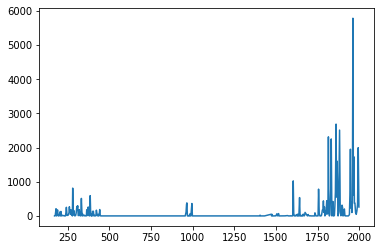

In [19]:
import matplotlib.pyplot as plt
plt.plot(train[train['meter'] == 1]['meter_reading'])
plt.show()

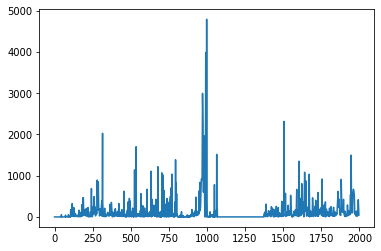

In [20]:
plt.plot(train[train['meter'] == 0]['meter_reading'])
plt.show()

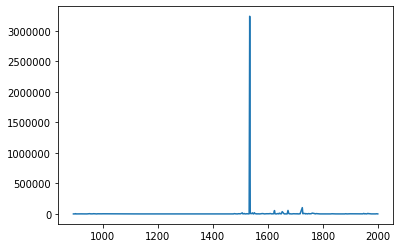

In [21]:
plt.plot(train[train['meter'] == 2]['meter_reading'])
plt.show()

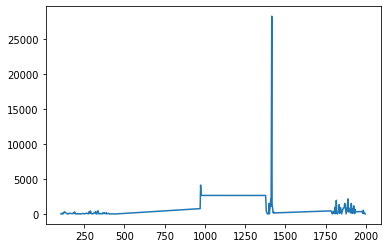

In [22]:
plt.plot(train[train['meter'] == 3]['meter_reading'])
plt.show()

## Imputation - Missing value 

### Floor_count (Method Linear regression)

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer

In [24]:
building_metadata_part = building_metadata[['building_id','site_id','primary_use','square_feet', 'floor_count']]
cols    = ['primary_use', 'site_id']
encode_df = pd.DataFrame()
for col in cols:
    lb_style   = LabelBinarizer()
    lb_results = lb_style.fit_transform(building_metadata_part[col])
    label_code = pd.DataFrame(lb_results, columns=lb_style.classes_)
    encode_df  = pd.concat([encode_df, label_code], axis=1)
    
buidling_encode = pd.concat([encode_df, building_metadata_part[['building_id','square_feet', 'floor_count']]], axis=1)
buidling_encode = buidling_encode.set_index('building_id')
test            = buidling_encode[buidling_encode['floor_count'].isnull()]
train           = buidling_encode[buidling_encode['floor_count'].notnull()]
model           = LinearRegression()
X_test          = test.drop(['floor_count'],axis=1)
X_train         = train.iloc[:,:-1].values
Y_train         = train['floor_count'].values
building_model  = model.fit(X_train, Y_train)
y_pred          = building_model.predict(X_test)
X_test['floor_count'] = np.around(y_pred).astype(int)
combine_data    = pd.concat([train, X_test], axis=0)
building_metadata_noNA = pd.merge(building_metadata[['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built']],
                            combine_data[['floor_count']], how='inner',left_index=True, right_index=True)

### Floor_count (Method MICE)

This type of imputation works by filling the missing data multiple times. 
Multiple Imputations (MIs) are much better than a single imputation as it measures the uncertainty of 
the missing values in a better way. The chained equations approach is also very flexible and can handle 
different variables of different data types (ie., continuous or binary) as well as complexities such as bounds 
or survey skip patterns.

In [46]:
# from impute.imputation.cs import mice
# imputed_floorcount = mice(building_metadata[['floor_count', 'square_feet']].values)

Other methods to calculate floor_counts
Group by siteid or primaryuse and then calculate specific means/medians to fill in.
Calculate mean energy consumption of building with missing floor_count, then find buildings with similar energy consumptions taking into account other comparable features.

 ### Weather data imputation (Method Rolling mean, median, min, max (3, 5, 7, 14, 30 days)

In [26]:
def rolling_mean_weather(df, cols, num_of_days):
    #assumes that functions will be mean, median, min, max
    for col in cols:
        for day in num_of_days:
            print ("processing missing values for", col, day)
            df[col+'_'+'R'+str(day)+'_'+'mean']   = df.groupby('site_id')[col].apply(lambda x: x.fillna(x.rolling(day, center=True, min_periods=1).mean()))
            df[col+'_'+'R'+str(day)+'_'+'median'] = df.groupby('site_id')[col].apply(lambda x: x.fillna(x.rolling(day, center=True, min_periods=1).median()))
            df[col+'_'+'R'+str(day)+'_'+'min']    = df.groupby('site_id')[col].apply(lambda x: x.fillna(x.rolling(day, center=True, min_periods=1).min()))
            df[col+'_'+'R'+str(day)+'_'+'max']    = df.groupby('site_id')[col].apply(lambda x: x.fillna(x.rolling(day, center=True, min_periods=1).max()))
cols_to_impute = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed' ]
weather_train  = rolling_mean_weather(weather_train, cols_to_impute, [3,5,7,14,30])

processing missing values for air_temperature 3
processing missing values for air_temperature 5
processing missing values for air_temperature 7
processing missing values for air_temperature 14
processing missing values for air_temperature 30
processing missing values for cloud_coverage 3
processing missing values for cloud_coverage 5
processing missing values for cloud_coverage 7
processing missing values for cloud_coverage 14
processing missing values for cloud_coverage 30
processing missing values for dew_temperature 3
processing missing values for dew_temperature 5
processing missing values for dew_temperature 7
processing missing values for dew_temperature 14
processing missing values for dew_temperature 30
processing missing values for precip_depth_1_hr 3
processing missing values for precip_depth_1_hr 5
processing missing values for precip_depth_1_hr 7
processing missing values for precip_depth_1_hr 14
processing missing values for precip_depth_1_hr 30
processing missing values f

## Date Preprocessing for train and weather

In [36]:
def change_datetime(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year']      = df['timestamp'].map(lambda x: x.strftime('%Y')).astype(int)
    df['month']     = df['timestamp'].map(lambda x: x.strftime('%m')).astype(int)
    df['weekday']   = df['timestamp'].map(lambda x: x.weekday()).astype(int)
    df['hour']      = df['timestamp'].map(lambda x: x.hour).astype(int)
    
    return df

def change_date(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year']      = pd.to_datetime(df['timestamp']).map(lambda x: x.strftime('%Y')).astype(int)
    df['month']     = df['timestamp'].map(lambda x: x.strftime('%m')).astype(int)
    df['weekday']   = df['timestamp'].map(lambda x: x.weekday()).astype(int)
    return df

weather_train   = change_datetime(weather_train)
train           = change_date(train)